In [14]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from transformers import (
    AutoModelForTokenClassification,
    AutoTokenizer,
    pipeline
)
import logging
import warnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from matplotlib.lines import Line2D  # Import Line2D for custom legend
from matplotlib.colors import LinearSegmentedColormap
from brokenaxes import brokenaxes

In [2]:
warnings.filterwarnings("ignore")
logging.disable(logging.INFO)

In [3]:
device = 0 if torch.cuda.is_available() else -1
device

-1

In [4]:
all_features = ['Active site', 'Binding site', 'DNA binding',
                'Topological domain', 'Transmembrane',
                 'Disulfide bond', 'Propeptide', 'Signal peptide', 'Transit peptide',
                'Beta strand', 'Helix',
                'Coiled coil', 'Compositional bias', 'Domain', 'Region', 'Repeat', 'Zinc finger']

all_features_re = ['ACT_SITE', 'BINDING', 'DNA_BIND',
                   'TOPO_DOM', 'TRANSMEM',
                   'DISULFID',  'PROPEP', 'SIGNAL', 'TRANSIT',
                   'STRAND', 'HELIX',
                   'COILED', 'COMPBIAS', 'DOMAIN', 'REGION', 'REPEAT', 'ZN_FING']

In [ ]:
def loss_or_gain(seq_ref, seq_mut):
  diff_results = {}

  for i in range(len(all_features)):
    feature_re = all_features_re[i]

    model_checkpoint = f"AliSaadatV/esm2_t12_35M_UR50D-finetuned-{feature_re}_earlystop_70_15_15"
    token_classifier = pipeline(
        "token-classification", model=model_checkpoint, device=device,
    )

    with torch.no_grad():
      output_ref = token_classifier(seq_ref)
      output_mut = token_classifier(seq_mut)


    scores_ref = []
    label_ref = []
    scores_mut = []
    label_mut = []

    for j in range(len(output_ref)):
      if output_ref[j]['entity'] == "LABEL_1":
        label_ref.append(1)
        scores_ref.append(output_ref[j]['score'])
      else:
        label_ref.append(0)
        scores_ref.append(1 - output_ref[j]['score'])

      if output_mut[j]['entity'] == "LABEL_1":
        label_mut.append(1)
        scores_mut.append(output_mut[j]['score'])
      else:
        label_mut.append(0)
        scores_mut.append(1 - output_mut[j]['score'])

    diff_label = np.array(label_mut) - np.array(label_ref)
    gain = np.where(diff_label>0.5)[0].tolist()
    loss = np.where(diff_label<-0.5)[0].tolist()
    diff_results[f"{feature_re}_loss"] = loss
    diff_results[f"{feature_re}_gain"] = gain

    diff_scores = np.array(scores_mut) - np.array(scores_ref)
    if len(gain) > 0:
      diff_results[f"{feature_re}_gain_score"] = diff_scores[gain]

    if len(loss) > 0:
      diff_results[f"{feature_re}_loss_score"] = diff_scores[loss]

  return diff_results


In [15]:
import seaborn as sns

def plot_diff_results(diff_results, sequence_length, gene, num_features=len(all_features), threshold=0):

  loss_matrix = np.zeros((num_features, sequence_length))
  gain_matrix = np.zeros((num_features, sequence_length))

  for i in range(num_features):
    feature_re = all_features_re[i]
    loss_positions = diff_results[f"{feature_re}_loss"]
    gain_positions = diff_results[f"{feature_re}_gain"]
    k = 0
    for pos in loss_positions:
        loss_matrix[i, pos - 1] = np.abs(diff_results[f"{feature_re}_loss_score"][k])
        k += 1
    k = 0
    for pos in gain_positions:
        gain_matrix[i, pos - 1] = np.abs(diff_results[f"{feature_re}_gain_score"][k])
        k += 1

  feature_matrix = gain_matrix - loss_matrix

  # Define a custom colormap and create a norm

  cmap = sns.color_palette("coolwarm", as_cmap=True).reversed()
  norm = plt.Normalize(-1, 1)

  # Create a figure and a set of subplots
  fig, ax = plt.subplots(figsize=(15, 7))


  # Set the background color
  fig.patch.set_facecolor('white')
  ax.set_facecolor('white')

  # Plot each point with a circular dot and add line connections to the axes
  for i in range(num_features):
      for j in range(sequence_length):
          if np.abs(feature_matrix[i, j]) > threshold:  # Only plot non-zero entries
              ax.scatter(j+2, i+1, marker='o', color=cmap(norm(feature_matrix[i, j])), s=50)
              #ax.plot([j + 2, j + 2], [0, i + 1], color='gray', linestyle='dashed', linewidth=0.5)  # Vertical
              #ax.plot([0, j + 2], [i + 1, i + 1], color='gray', linestyle='dashed', linewidth=0.5)  # Horizontal


  # Set labels and title
  ax.set_xlim([0, sequence_length + 1])  # Extend x-axis from 0 to the length of sequence +1 for better visibility
  ax.set_ylim([0, num_features + 1])
  ax.set_xlabel('Position')
  ax.set_xticks(list(range(0, sequence_length//50*50+1, 50)))
  #positions_with_changes = {j+2 for i in range(num_features) for j in range(sequence_length) if np.abs(feature_matrix[i, j]) > threshold}
  #ax.set_xticks(sorted(list(positions_with_changes)))
  #ax.set_xticklabels(sorted(list(positions_with_changes)), rotation=45, fontsize=5)  # Label positions with changes
  ax.set_yticks(range(1, num_features+1))
  ax.set_yticklabels(all_features)

  sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
  sm.set_array([])  # Fake up the array of the scalar mappable for the colorbar
  cbar = plt.colorbar(sm, ax=ax)
  cbar.ax.get_yaxis().labelpad = 15
  cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
  cbar.set_ticklabels(['-1', '-0.5', '0', '0.5', '1'])
  cbar.ax.text(1.0, -0.05, 'Loss', va='bottom', ha='right', transform=cbar.ax.transAxes, fontsize=10)
  cbar.ax.text(1.0, 1.05, 'Gain', va='bottom', ha='right', transform=cbar.ax.transAxes, fontsize=10)

  # Create a custom legend
  #legend_elements = [Line2D([0], [0], marker='o', color='w', label='Loss', markerfacecolor='red', markersize=10),
                    #Line2D([0], [0], marker='o', color='w', label='Gain', markerfacecolor='blue', markersize=10)]
  #ax.legend(handles=legend_elements, loc='upper right')

  plt.savefig(f'{gene}_threshold{threshold}.png', format='png', dpi=300, bbox_inches='tight')
  # Show the plot
  plt.show()

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_diff_results_zoomed(diff_results, sequence_length, gene, num_features=len(all_features), threshold=0):

  loss_matrix = np.zeros((num_features, sequence_length))
  gain_matrix = np.zeros((num_features, sequence_length))

  for i in range(num_features):
    feature_re = all_features_re[i]
    loss_positions = diff_results[f"{feature_re}_loss"]
    gain_positions = diff_results[f"{feature_re}_gain"]
    k = 0
    for pos in loss_positions:
        loss_matrix[i, pos - 1] = np.abs(diff_results[f"{feature_re}_loss_score"][k])
        k += 1
    k = 0
    for pos in gain_positions:
        gain_matrix[i, pos - 1] = np.abs(diff_results[f"{feature_re}_gain_score"][k])
        k += 1

  feature_matrix = gain_matrix - loss_matrix

  # Define a custom colormap and create a norm
  cmap = sns.color_palette("coolwarm", as_cmap=True).reversed()
  norm = plt.Normalize(-1, 1)

  # Create two subplots side by side
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), sharey=True, gridspec_kw={'width_ratios': [4, 1], 'wspace': 0.05})

  # Plot data on both axes
  for ax in [ax1, ax2]:
      for i in range(num_features):
          for j in range(sequence_length):
              if np.abs(feature_matrix[i, j]) > threshold:  # Only plot non-zero entries
                  if ax == ax1 and j < sequence_length // 2:
                      ax.scatter(j+2, i+1, marker='o', color=cmap(norm(feature_matrix[i, j])), s=50)
                      ax.plot([0, j + 2], [i + 1, i + 1], color='gray', linestyle='dashed', linewidth=0.5)
                  elif ax == ax2 and j >= sequence_length // 2:
                      ax.scatter(j+2 - sequence_length // 2, i+1, marker='o', color=cmap(norm(feature_matrix[i, j])), s=50)

  # Adjust axes limits and spines
  ax1.set_xlim(0, sequence_length // 4)
  ax1.set_xticks(list(range(0, sequence_length//4, 50)))
  ax2.set_xlim(sequence_length//10 * 9, sequence_length)  # Adjust this based on your data
  ax2.set_xticks(list(range((sequence_length//10 * 9)//50 * 50, sequence_length, 50)))

  # Hide the spines and ticks to make it look like a single continuous axis
  ax1.spines['right'].set_visible(False)
  ax2.spines['left'].set_visible(False)
  ax1.yaxis.tick_left()
  ax2.yaxis.tick_right()
  ax2.tick_params(labelleft=False)


  # Adding diagonal cut lines to indicate a break in the axis
  d = .012  # proportion of vertical to horizontal extent of the slanted line
  kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
  ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
  ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

  kwargs.update(transform=ax2.transAxes)  # apply the transformation to the second axis
  ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
  ax2.plot((-d, +d), (-d, +d), **kwargs)

  ax1.set_xlabel('Amino acid position')
  ax2.set_xlabel('')
  ax1.set_yticks(range(1, num_features+1))
  ax1.set_yticklabels(all_features)
  #ax2.set_yticklabels([])  # remove y labels on the second plot

  sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
  sm.set_array([])  # Fake up the array of the scalar mappable. Necessary since no mappable object was actually created.
  cbar = plt.colorbar(sm, ax=[ax1, ax2], aspect=20)
  cbar.ax.get_yaxis().labelpad = 15
  cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
  cbar.set_ticklabels(['-1', '-0.5', '0', '0.5', '1'])
  cbar.ax.text(1.0, -0.05, 'Loss', va='bottom', ha='right', transform=cbar.ax.transAxes, fontsize=10)
  cbar.ax.text(1.0, 1.05, 'Gain', va='bottom', ha='right', transform=cbar.ax.transAxes, fontsize=10)

  plt.savefig(f'{gene}_threshold{threshold}.png', format='png', dpi=300, bbox_inches='tight')

  plt.show()



### run for all pathogenic/benign missense variants from ClinGen

In [ ]:
clingen_vars = pd.read_csv("clingen_onlymissense_bothPandB_54genes.tsv", sep = "\t")
clingen_vars.head()

,#Variation,ClinVar Variation Id,Allele Registry Id,HGVS Expressions,SYMBOL,Disease,Mondo Id,Mode of Inheritance,Assertion,Applied Evidence Codes (Met),...,Retracted,Evidence Repo Link,Uuid,mutation,AA1,AA_pos,AA2,Sequence,Length,uniprot_entry
0,NM_206933.2(USH2A):c.15562A>G (p.Ser5188Gly),48468,CA143409,"NM_206933.2:c.15562A>G, NC_000001.11:g.2156258...",USH2A,Usher syndrome,MONDO:0019501,Autosomal recessive inheritance,Benign,BA1,...,False,https://erepo.genome.network/evrepo/ui/classif...,6ea1fef2-f5b3-4739-8738-c6bf29fea20a,p.Ser5188Gly,Ser,5188,Gly,MNCPVLSLGSGFLFQVIEMLIFAYFASISLTESRGLFPRLENVGAF...,5202,O75445
1,NM_000441.1(SLC26A4):c.1363A>T (p.Ile455Phe),43507,CA132664,"NM_000441.1:c.1363A>T, NC_000007.14:g.10769464...",SLC26A4,Pendred syndrome,MONDO:0010134,Autosomal recessive inheritance,Benign,"PP3, BA1",...,False,https://erepo.genome.network/evrepo/ui/classif...,2b9fd19d-de91-41b2-a416-dc26fa5062e4,p.Ile455Phe,Ile,455,Phe,MAAPGGRSEPPQLPEYSCSYMVSRPVYSELAFQQQHERRLQERKTL...,780,O43511
2,NM_000441.1(SLC26A4):c.565G>T (p.Ala189Ser),43560,CA132732,"NM_000441.1:c.565G>T, NC_000007.14:g.107674313...",SLC26A4,Pendred syndrome,MONDO:0010134,Autosomal recessive inheritance,Benign,BA1,...,False,https://erepo.genome.network/evrepo/ui/classif...,b905ae85-8973-4ed6-b603-52b3b342f2e0,p.Ala189Ser,Ala,189,Ser,MAAPGGRSEPPQLPEYSCSYMVSRPVYSELAFQQQHERRLQERKTL...,780,O43511
3,NM_000257.4(MYH7):c.4130C>T (p.Thr1377Met),42992,CA014494,"NM_000257.4:c.4130C>T, NC_000014.9:g.23418249G...",MYH7,hypertrophic cardiomyopathy,MONDO:0005045,Autosomal dominant inheritance,Pathogenic,"PS4, PM2, PP3, PP1_Strong",...,False,https://erepo.genome.network/evrepo/ui/classif...,f4dea66d-87b3-467f-862c-c239472e6930,p.Thr1377Met,Thr,1377,Met,MGDSEMAVFGAAAPYLRKSEKERLEAQTRPFDLKKDVFVPDDKQEF...,1935,P12883
4,NM_000257.4(MYH7):c.4066G>A (p.Glu1356Lys),164294,CA014400,"NM_000257.4:c.4066G>A, NC_000014.9:g.23418313C...",MYH7,hypertrophic cardiomyopathy,MONDO:0005045,Autosomal dominant inheritance,Pathogenic,"PS4, PM2, PP3, PP1_Strong",...,False,https://erepo.genome.network/evrepo/ui/classif...,8112b9be-baa4-485d-a686-c223e112af4e,p.Glu1356Lys,Glu,1356,Lys,MGDSEMAVFGAAAPYLRKSEKERLEAQTRPFDLKKDVFVPDDKQEF...,1935,P12883


In [ ]:
amino_acids_data = [
    ["Ala", "A"],
    ["Arg", "R"],
    ["Asn", "N"],
    ["Asp", "D"],
    [ "Cys", "C"],
    [ "Gln", "Q"],
    [ "Glu", "E"],
    ["Gly", "G"],
    ["His", "H"],
    ["Ile", "I"],
    ["Leu", "L"],
    ["Lys", "K"],
    [ "Met", "M"],
    [ "Phe", "F"],
    [ "Pro", "P"],
    ["Ser", "S"],
    [ "Thr", "T"],
    [ "Trp", "W"],
    [ "Tyr", "Y"],
    [ "Val", "V"]
]

# Create a DataFrame
df_amino_acids = pd.DataFrame(amino_acids_data, columns=["AA2", "AA2_symbol"])

# add AA symbol to clingen
clingen_vars = clingen_vars.merge(df_amino_acids, how="left", on="AA2")

In [ ]:
clingen_vars['diff_results'] = None

for idx, row in clingen_vars.iterrows():
  print(idx)
  ref_seq = row["Sequence"]
  var_pos = row["AA_pos"] - 1
  mut_seq = ref_seq[:var_pos] + row["AA2_symbol"] + ref_seq[var_pos+1:]
  clingen_vars.at[idx, 'diff_results'] = loss_or_gain(ref_seq, mut_seq)

clingen_vars.to_csv("clingen_onlymissense_bothPandB_54genes_withDiffRes.tsv", sep="\t")

Analyze predictions

In [6]:
import re
import ast

def preprocess_and_extract(dict_string):
    # Preprocess to replace numpy array with list
    dict_string = re.sub(r'\s+', ' ', dict_string)  # Simplify all whitespace to single spaces
    dict_string = re.sub(r"array\(\s*\[([^\]]+)\]\s*\)", r"[\1]", dict_string)  # Replace 'array([...])' with '[...]'

    # Regex pattern to match keys and values in the dictionary string
    pattern = r"'(\w+)': (\[.*?\])"

    # Find all matches of the pattern in the string
    matches = re.findall(pattern, dict_string)

    result_dict = {}
    for key, value_str in matches:
        # Evaluate the list safely, converting it back from string to list/array
        try:
            # If the value is formatted like a list, convert it
            value = eval(value_str)
        except:
            value = value_str

        result_dict[key] = value

    return result_dict


clingen_vars = pd.read_csv("clingen_onlymissense_bothPandB_54genes_withDiffRes.tsv", sep="\t")
clingen_vars["diff_results"] = clingen_vars["diff_results"].apply(preprocess_and_extract)
clingen_vars.head()

,Unnamed: 0,#Variation,ClinVar Variation Id,Allele Registry Id,HGVS Expressions,SYMBOL,Disease,Mondo Id,Mode of Inheritance,Assertion,...,Uuid,mutation,AA1,AA_pos,AA2,Sequence,Length,uniprot_entry,AA2_symbol,diff_results
0,0,NM_206933.2(USH2A):c.15562A>G (p.Ser5188Gly),48468,CA143409,"NM_206933.2:c.15562A>G, NC_000001.11:g.2156258...",USH2A,Usher syndrome,MONDO:0019501,Autosomal recessive inheritance,Benign,...,6ea1fef2-f5b3-4739-8738-c6bf29fea20a,p.Ser5188Gly,Ser,5188,Gly,MNCPVLSLGSGFLFQVIEMLIFAYFASISLTESRGLFPRLENVGAF...,5202,O75445,G,"{'ACT_SITE_loss': [], 'ACT_SITE_gain': [], 'BI..."
1,1,NM_000441.1(SLC26A4):c.1363A>T (p.Ile455Phe),43507,CA132664,"NM_000441.1:c.1363A>T, NC_000007.14:g.10769464...",SLC26A4,Pendred syndrome,MONDO:0010134,Autosomal recessive inheritance,Benign,...,2b9fd19d-de91-41b2-a416-dc26fa5062e4,p.Ile455Phe,Ile,455,Phe,MAAPGGRSEPPQLPEYSCSYMVSRPVYSELAFQQQHERRLQERKTL...,780,O43511,F,"{'ACT_SITE_loss': [], 'ACT_SITE_gain': [], 'BI..."
2,2,NM_000441.1(SLC26A4):c.565G>T (p.Ala189Ser),43560,CA132732,"NM_000441.1:c.565G>T, NC_000007.14:g.107674313...",SLC26A4,Pendred syndrome,MONDO:0010134,Autosomal recessive inheritance,Benign,...,b905ae85-8973-4ed6-b603-52b3b342f2e0,p.Ala189Ser,Ala,189,Ser,MAAPGGRSEPPQLPEYSCSYMVSRPVYSELAFQQQHERRLQERKTL...,780,O43511,S,"{'ACT_SITE_loss': [], 'ACT_SITE_gain': [], 'BI..."
3,3,NM_000257.4(MYH7):c.4130C>T (p.Thr1377Met),42992,CA014494,"NM_000257.4:c.4130C>T, NC_000014.9:g.23418249G...",MYH7,hypertrophic cardiomyopathy,MONDO:0005045,Autosomal dominant inheritance,Pathogenic,...,f4dea66d-87b3-467f-862c-c239472e6930,p.Thr1377Met,Thr,1377,Met,MGDSEMAVFGAAAPYLRKSEKERLEAQTRPFDLKKDVFVPDDKQEF...,1935,P12883,M,"{'ACT_SITE_loss': [], 'ACT_SITE_gain': [], 'BI..."
4,4,NM_000257.4(MYH7):c.4066G>A (p.Glu1356Lys),164294,CA014400,"NM_000257.4:c.4066G>A, NC_000014.9:g.23418313C...",MYH7,hypertrophic cardiomyopathy,MONDO:0005045,Autosomal dominant inheritance,Pathogenic,...,8112b9be-baa4-485d-a686-c223e112af4e,p.Glu1356Lys,Glu,1356,Lys,MGDSEMAVFGAAAPYLRKSEKERLEAQTRPFDLKKDVFVPDDKQEF...,1935,P12883,K,"{'ACT_SITE_loss': [], 'ACT_SITE_gain': [], 'BI..."


In [8]:
import re
import ast

threshold = 0.5
num_features = len(all_features)

for feature_re in all_features_re:
  clingen_vars[f"n_gain_{feature_re}"] = 0
  clingen_vars[f"n_loss_{feature_re}"] = 0

for idx, row in clingen_vars.iterrows():
  sequence_length = row["Length"]
  diff_results = row["diff_results"]

  loss_matrix = np.zeros((num_features, sequence_length))
  gain_matrix = np.zeros((num_features, sequence_length))

  for i in range(num_features):
    feature_re = all_features_re[i]
    loss_positions = diff_results[f"{feature_re}_loss"]
    gain_positions = diff_results[f"{feature_re}_gain"]
    k = 0
    for pos in loss_positions:
        loss_matrix[i, pos - 1] = np.abs(diff_results[f"{feature_re}_loss_score"][k])
        k += 1
    k = 0
    for pos in gain_positions:
        gain_matrix[i, pos - 1] = np.abs(diff_results[f"{feature_re}_gain_score"][k])
        k += 1

  feature_matrix = gain_matrix - loss_matrix

  for j in range(len(all_features_re)):
    feature_re = all_features_re[j]
    clingen_vars.loc[idx, f"n_loss_{feature_re}"] = np.sum(feature_matrix[j,:] < -threshold)
    clingen_vars.loc[idx, f"n_gain_{feature_re}"] = np.sum(feature_matrix[j,:] > threshold)

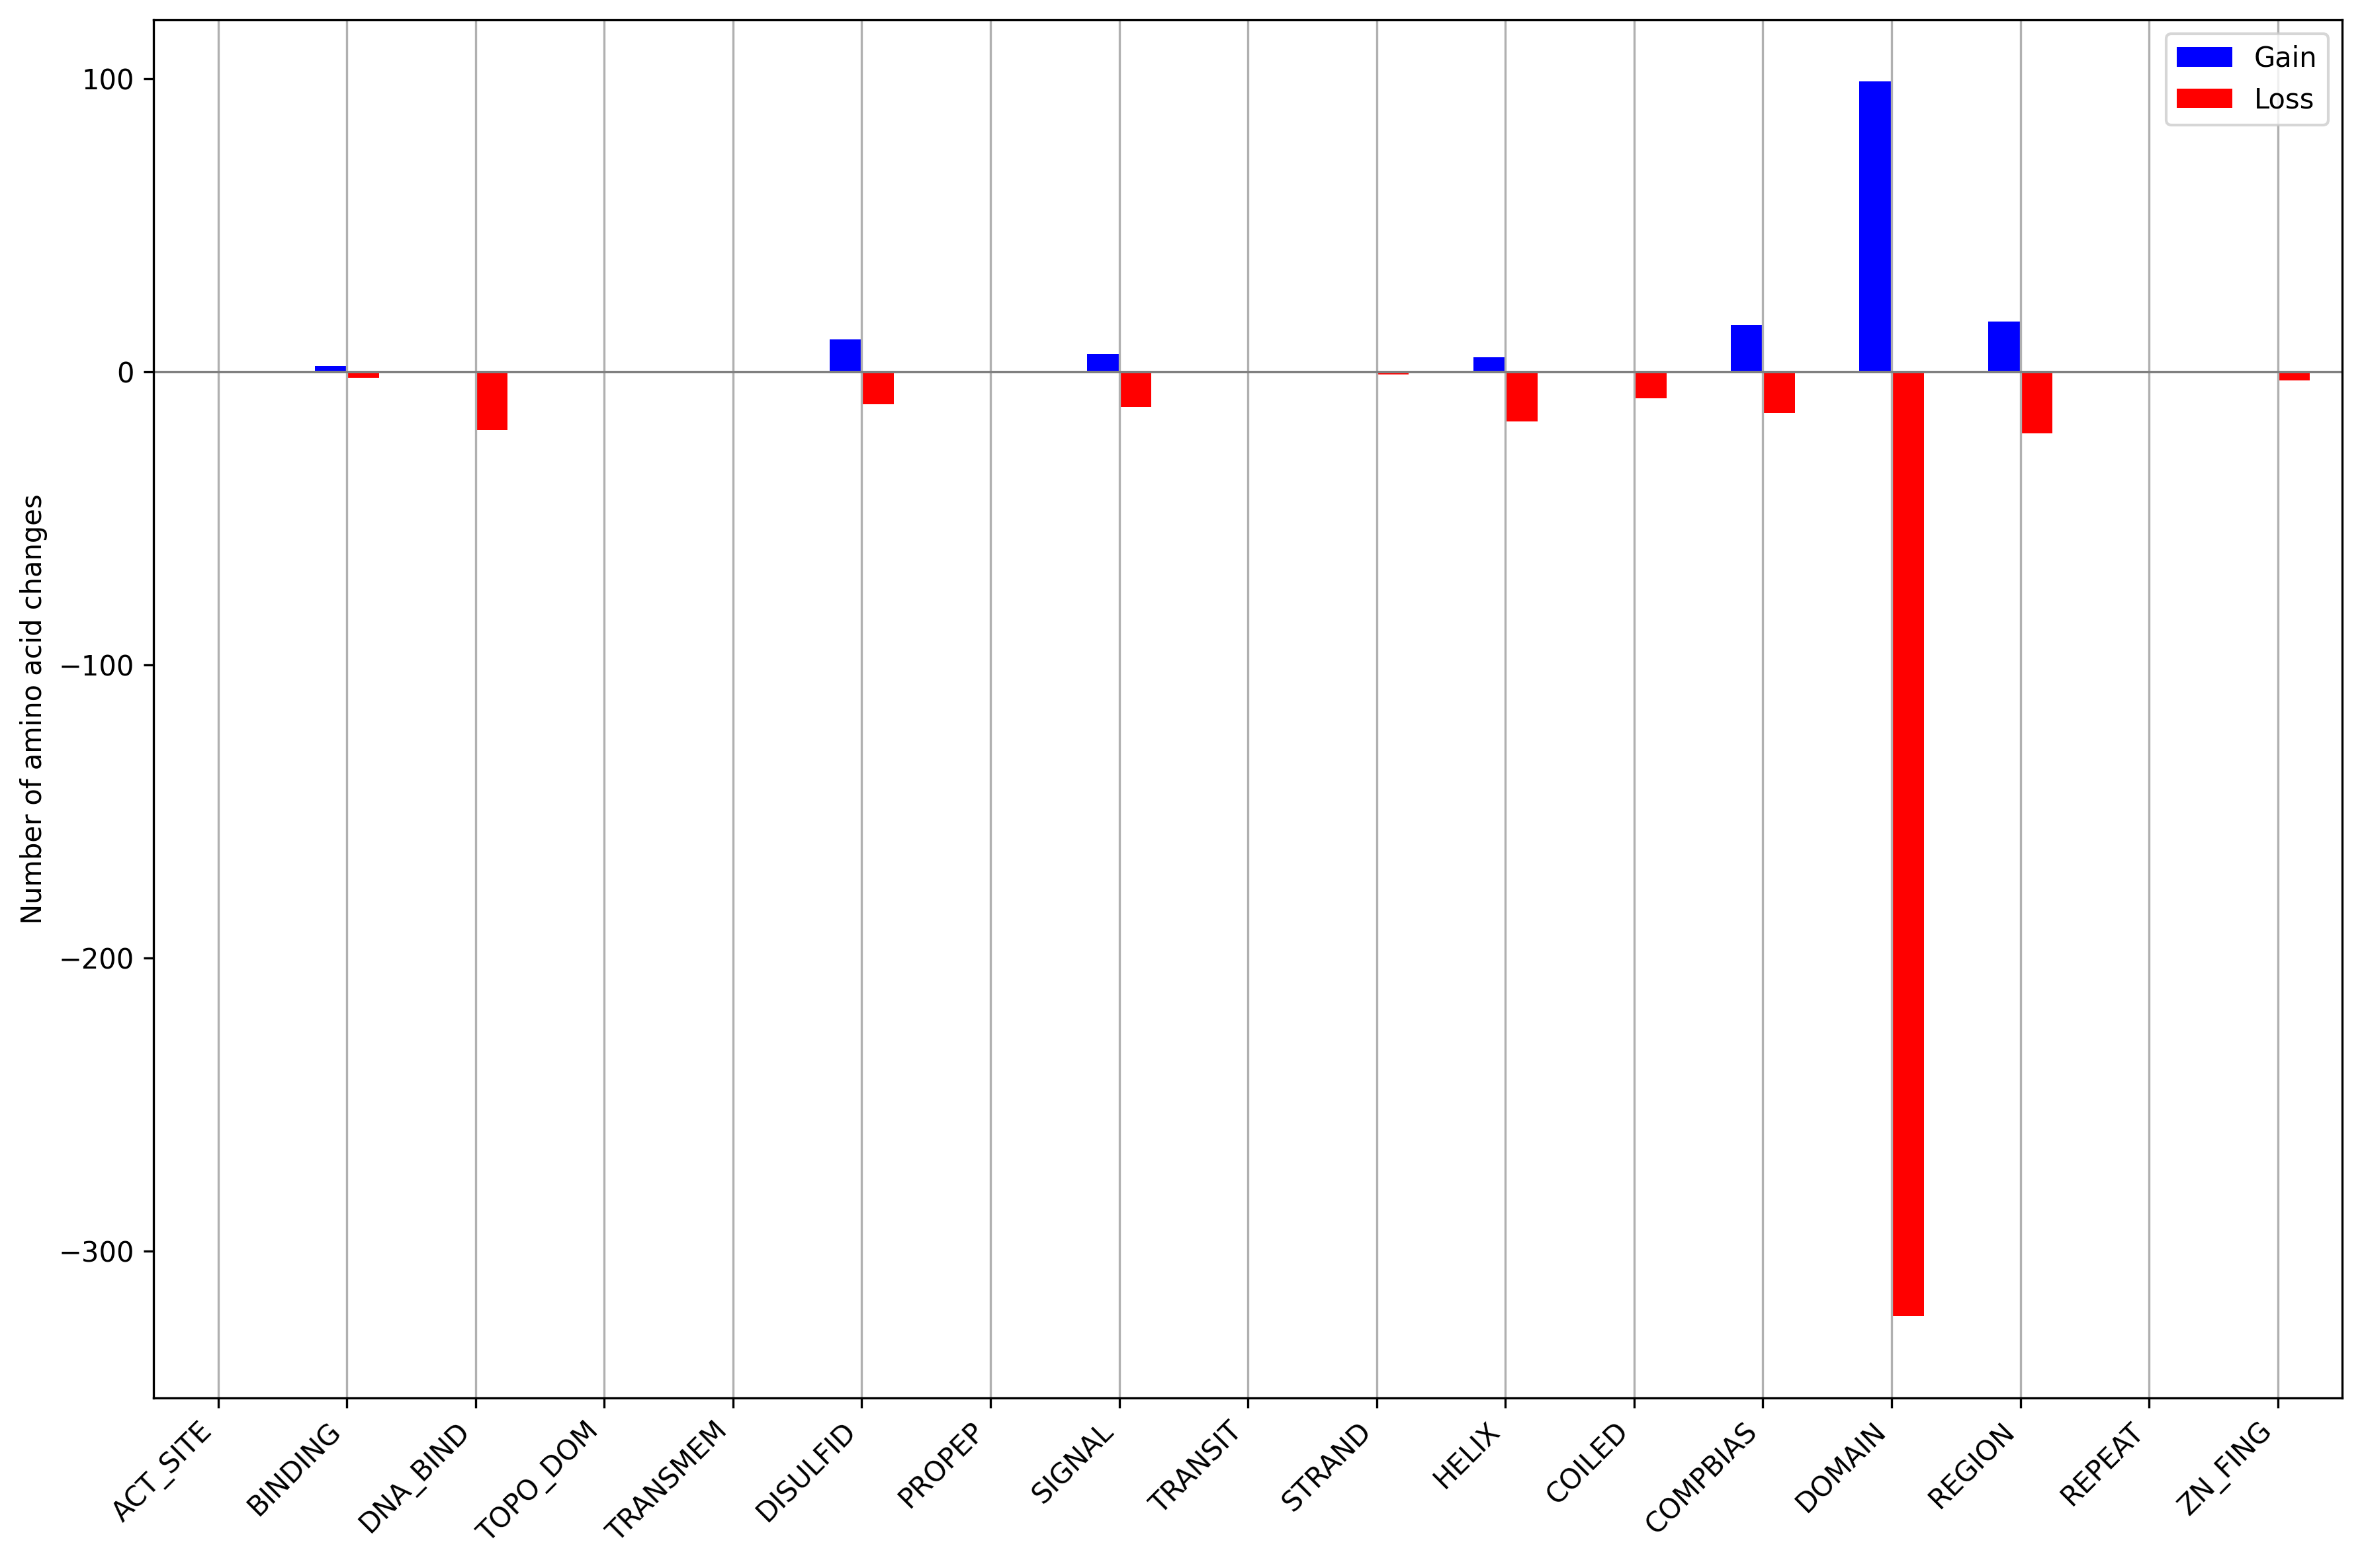

In [9]:
patho_changes = clingen_vars.loc[clingen_vars["Assertion"]=="Pathogenic", "n_gain_ACT_SITE":"n_loss_ZN_FING"].sum()

patho_changes_df = {'Feature': [], 'Gain': [], 'Loss': []}
for feature_re in all_features_re:
  patho_changes_df["Feature"].append(feature_re)
  patho_changes_df["Gain"].append(patho_changes[f"n_gain_{feature_re}"])
  patho_changes_df["Loss"].append(-patho_changes[f"n_loss_{feature_re}"])

patho_changes_df = pd.DataFrame(patho_changes_df)
patho_changes_df.set_index('Feature', inplace=True)

# Plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)  # Increased dpi for high quality
patho_changes_df.plot(kind='bar', ax=ax, color={'Gain': 'blue', 'Loss': 'red'})
ax.set_ylabel('Number of amino acid changes')
ax.axhline(0, color='grey', linewidth=0.8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xlabel('')  # Remove x-axis title
ax.xaxis.grid(True)
ax.set_ylim(-350, 120)

plt.tight_layout()
plt.savefig("AAchanges_patho_barplot.png", format='png', bbox_inches='tight', dpi=300)
plt.show()

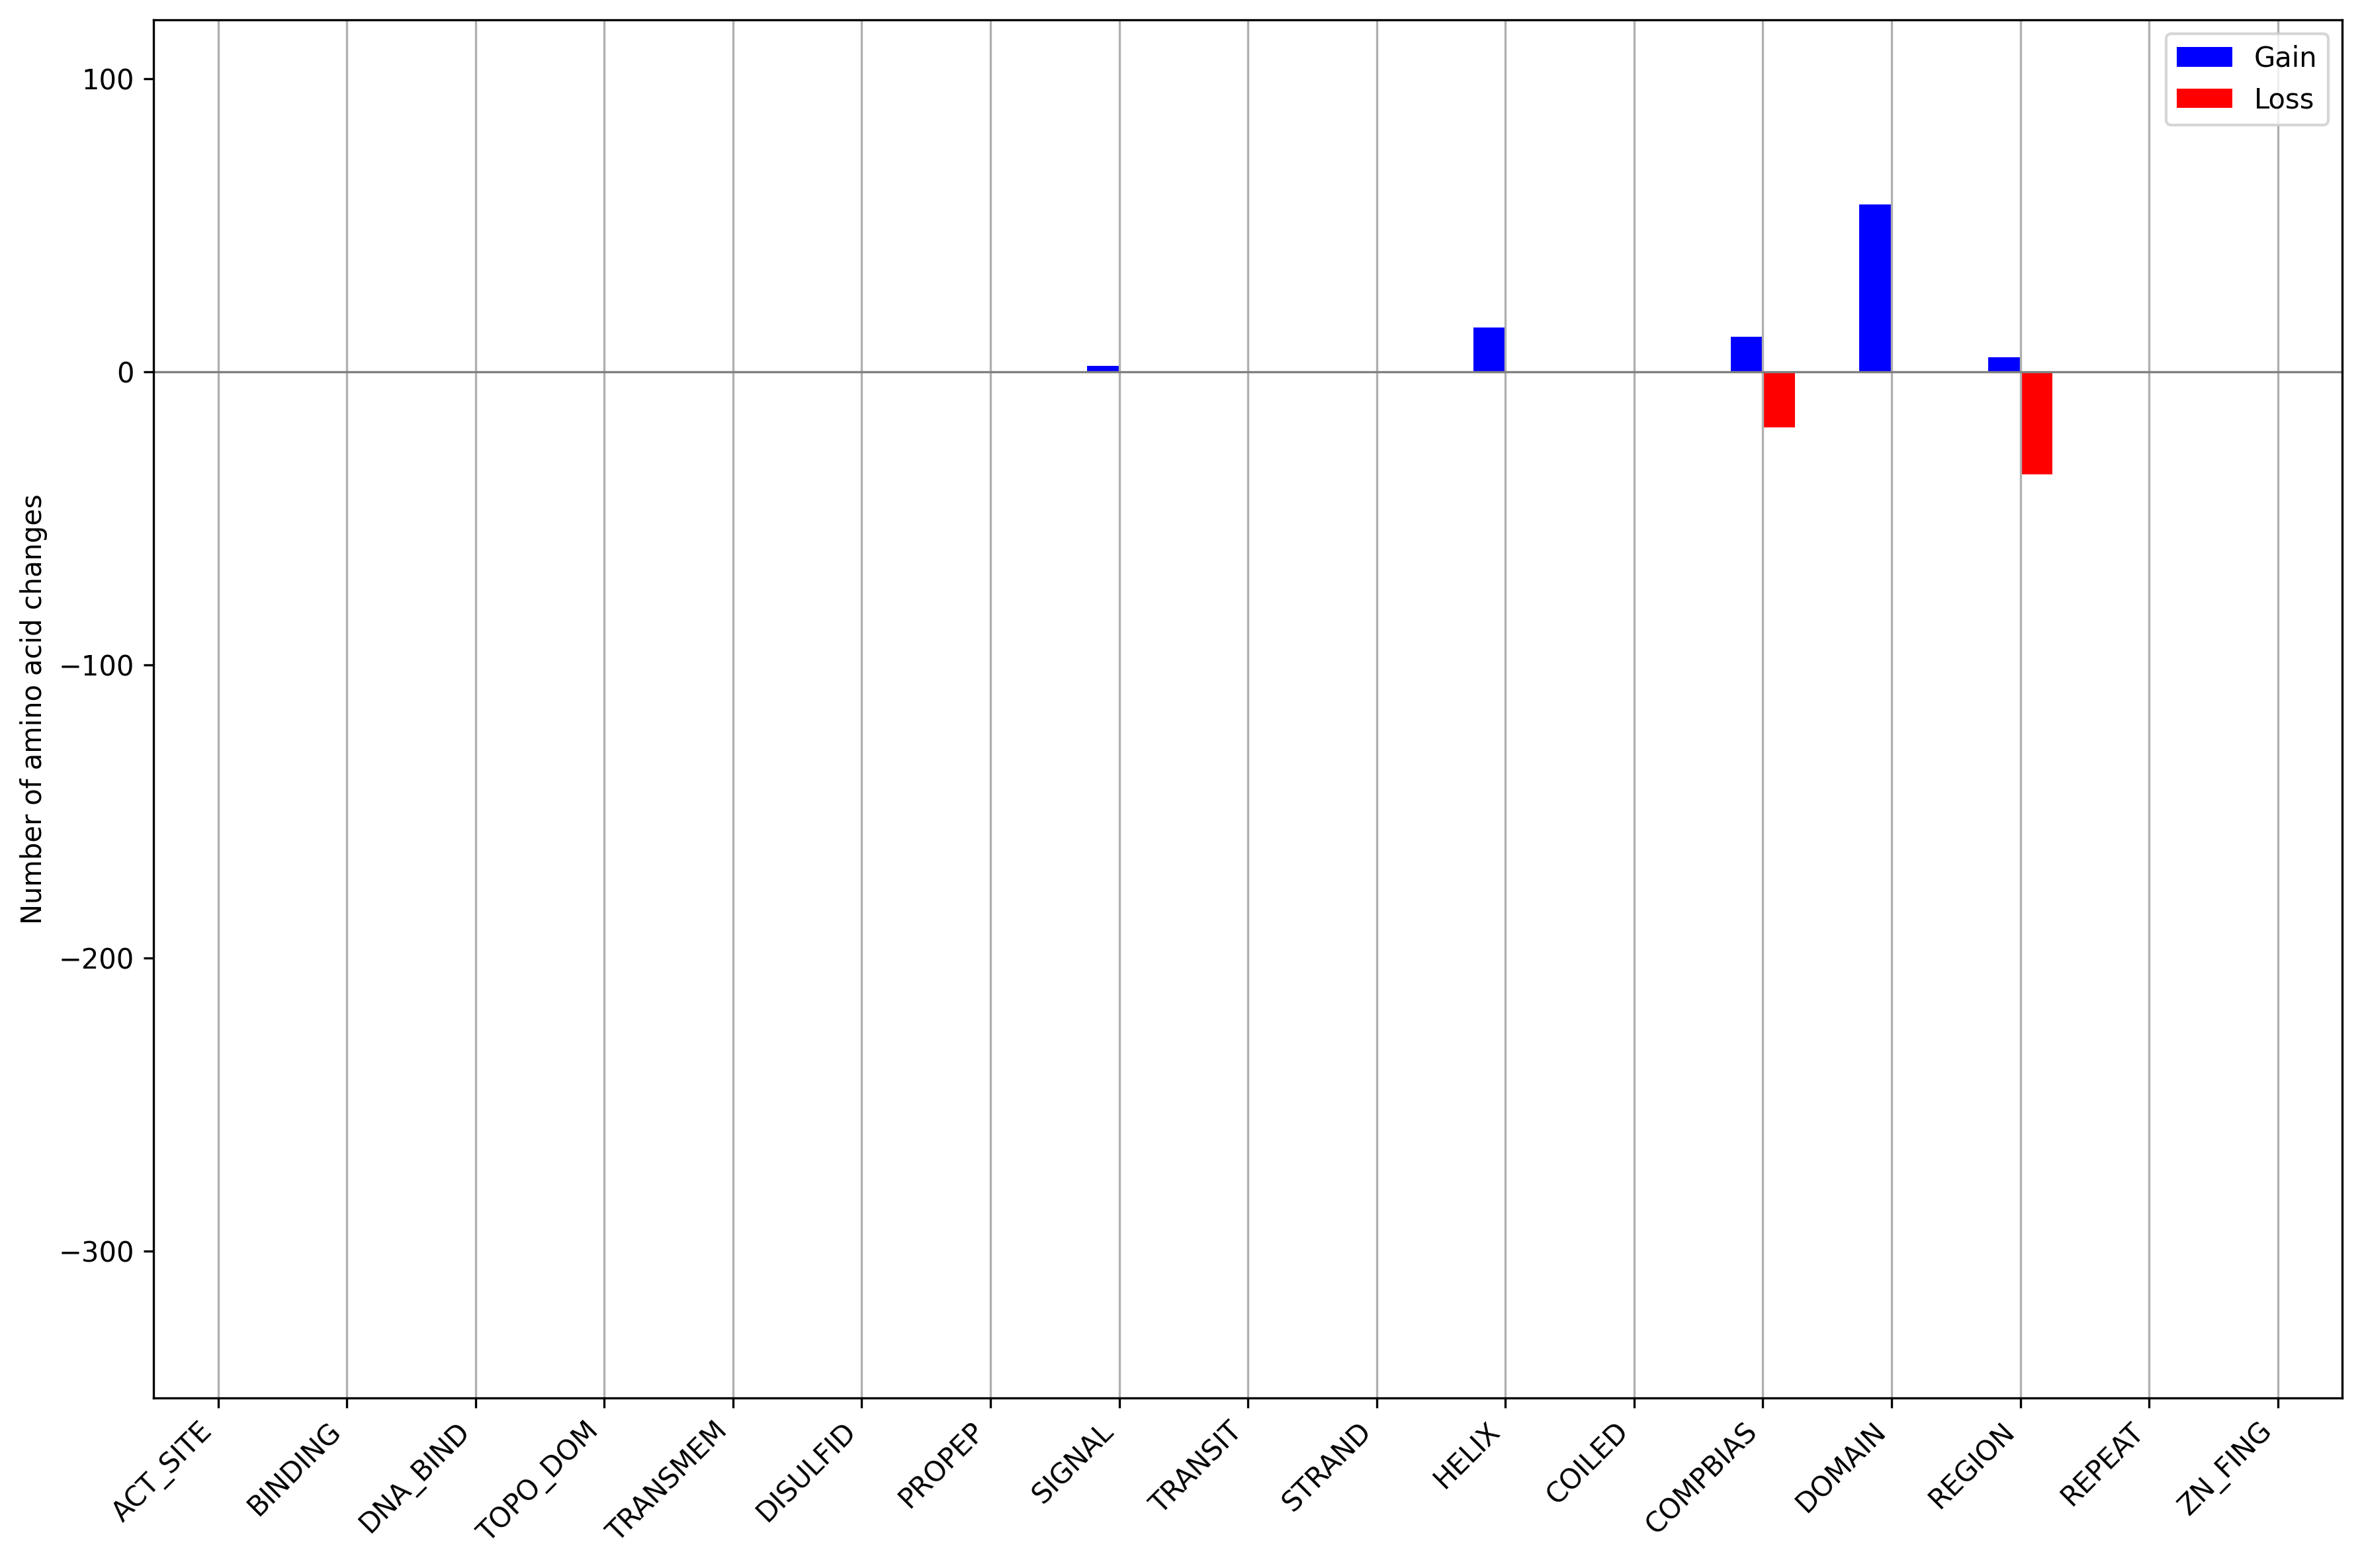

In [10]:
benign_changes = clingen_vars.loc[clingen_vars["Assertion"]=="Benign", "n_gain_ACT_SITE":"n_loss_ZN_FING"].sum()

benign_changes_df = {'Feature': [], 'Gain': [], 'Loss': []}
for feature_re in all_features_re:
  benign_changes_df["Feature"].append(feature_re)
  benign_changes_df["Gain"].append(benign_changes[f"n_gain_{feature_re}"])
  benign_changes_df["Loss"].append(-benign_changes[f"n_loss_{feature_re}"])

benign_changes_df = pd.DataFrame(benign_changes_df)
benign_changes_df.set_index('Feature', inplace=True)

# Plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)  # Increased dpi for high quality
benign_changes_df.plot(kind='bar', ax=ax, color={'Gain': 'blue', 'Loss': 'red'})
ax.set_ylabel('Number of amino acid changes')
ax.axhline(0, color='grey', linewidth=0.8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xlabel('')  # Remove x-axis title
ax.xaxis.grid(True)
ax.set_ylim(-350, 120)

plt.tight_layout()
plt.savefig("AAchanges_benign_barplot.png", format='png', bbox_inches='tight', dpi=300)
plt.show()

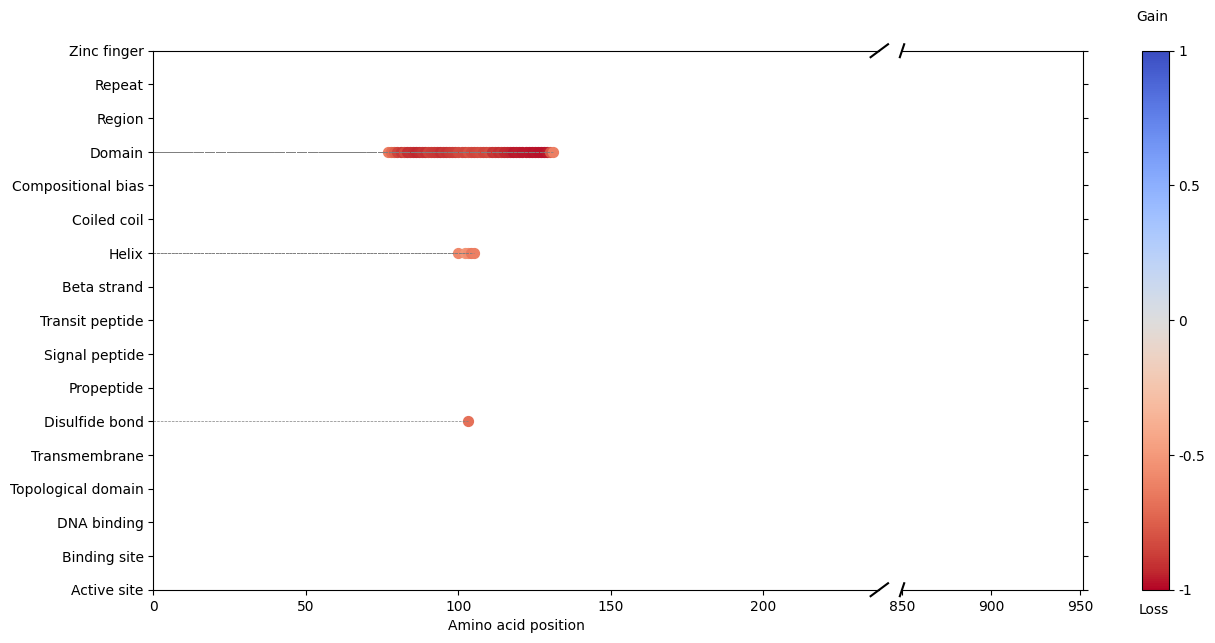

In [69]:
example1_idx = clingen_vars["n_loss_DOMAIN"].idxmax()

plot_diff_results_zoomed(clingen_vars.iloc[example1_idx]["diff_results"],
                  clingen_vars.iloc[example1_idx]["Length"],
                  gene=f"{clingen_vars.iloc[example1_idx]['SYMBOL']}",
                  threshold=0.5)

In [ ]:
clingen_vars.iloc[example1_idx]

Unnamed: 0                                                            486
#Variation                        NM_000152.3(GAA):c.307T>G (p.Cys103Gly)
ClinVar Variation Id                                                92483
Allele Registry Id                                               CA220404
HGVS Expressions        NM_000152.3:c.307T>G, NC_000017.11:g.80104893T...
                                              ...                        
n_loss_REGION                                                           0
n_gain_REPEAT                                                           0
n_loss_REPEAT                                                           0
n_gain_ZN_FING                                                          0
n_loss_ZN_FING                                                          0
Name: 486, Length: 66, dtype: object

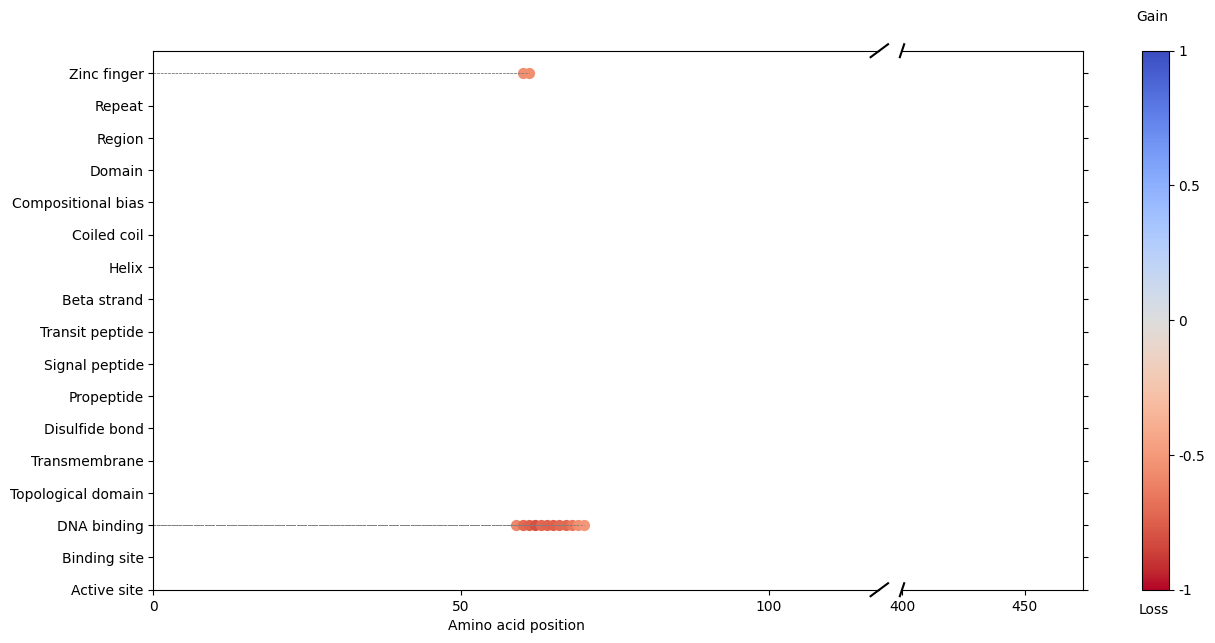

In [70]:
example2_idx = clingen_vars["n_loss_DNA_BIND"].idxmax()

plot_diff_results_zoomed(clingen_vars.iloc[example2_idx]["diff_results"],
                  clingen_vars.iloc[example2_idx]["Length"],
                  gene=f"{clingen_vars.iloc[example2_idx]['SYMBOL']}",
                  threshold=0.5)

In [ ]:
clingen_vars.iloc[example2_idx]

{'ACT_SITE_loss': [],
 'ACT_SITE_gain': [],
 'BINDING_loss': [],
 'BINDING_gain': [79, 114],
 'BINDING_gain_score': [0.34367228, 0.3377471],
 'DNA_BIND_loss': [58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
 'DNA_BIND_gain': [],
 'DNA_BIND_loss_score': [-0.58816415,
  -0.71117622,
  -0.74871266,
  -0.80473787,
  -0.72620332,
  -0.74213898,
  -0.74904078,
  -0.71759683,
  -0.71487159,
  -0.65218204,
  -0.54625106,
  -0.51101094],
 'TOPO_DOM_loss': [],
 'TOPO_DOM_gain': [],
 'TRANSMEM_loss': [],
 'TRANSMEM_gain': [],
 'DISULFID_loss': [],
 'DISULFID_gain': [],
 'PROPEP_loss': [],
 'PROPEP_gain': [],
 'SIGNAL_loss': [],
 'SIGNAL_gain': [],
 'TRANSIT_loss': [],
 'TRANSIT_gain': [],
 'STRAND_loss': [],
 'STRAND_gain': [],
 'HELIX_loss': [230],
 'HELIX_gain': [361],
 'HELIX_gain_score': [0.0824008],
 'HELIX_loss_score': [-0.0496248],
 'COILED_loss': [],
 'COILED_gain': [],
 'COMPBIAS_loss': [],
 'COMPBIAS_gain': [],
 'DOMAIN_loss': [152],
 'DOMAIN_gain': [],
 'DOMAIN_loss_score': [-0.03871